In [118]:
using Revise

Unexpected end of input
 ...when parsing byte with value '0'
Stacktrace:
 [1] _error(::String, ::JSON.Parser.StreamingParserState{TCPSocket}) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:148
 [2] byteat(::JSON.Parser.StreamingParserState{TCPSocket}) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:58
 [3] chomp_space! at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:115 [inlined]
 [4] parse_value(::JSON.Parser.ParserContext{Dict{String,Any},Int64}, ::JSON.Parser.StreamingParserState{TCPSocket}) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:158
 [5] #parse#2(::Type{Dict{String,Any}}, ::Type{Int64}, ::Function, ::TCPSocket) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:406
 [6] macro expansion at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Lazy/src/macros.jl:241 [i

In [119]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using RigidBodyDynamics.Contact
using Flux
using ProgressMeter
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models
using Blink

In [120]:
vis = Visualizer()
open(vis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 7893`, ProcessRunning), TCPSocket(RawFD(73) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(8, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(78) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 8, Nullable{Any}(true))))

In [121]:
using GeometryTypes

In [122]:
delete!(vis)
robot = CartPole(add_contacts=false, parameter_states=["wall_distance"])
mvis = MechanismVisualizer(robot, vis)

setobject!(vis[:leftwall], HyperRectangle(Vec(-0.001, -0.5, -1.5), Vec(0.002, 1.0, 3.0)))
setobject!(vis[:rightwall], HyperRectangle(Vec(-0.001, -0.5, -1.5), Vec(0.002, 1.0, 3.0)))

MeshCat Visualizer with path /meshcat/rightwall

In [123]:
using CoordinateTransformations

In [124]:
function move_walls_in_vis(mvis::MechanismVisualizer, distance)
    settransform!(mvis.visualizer[:leftwall], Translation(-distance, 0, 0))
    settransform!(mvis.visualizer[:rightwall], Translation(distance, 0, 0))
end

move_walls_in_vis (generic function with 2 methods)

In [125]:
params = MPCParams(robot)
lqrsol = LQRSolution(robot, params)
net, loss = LearningMPC.interval_net([5, 24, 24, 1]; regularization=1e-6, penalty = identity)
optimizer = Flux.ADAM(Flux.params(net); decay=1e-8)

net_cost = LearningMPC.LearnedCost(lqrsol, net)

net_mpc_params = MPCParams(robot)
net_mpc_params.horizon = 1
net_mpc_controller = MPCController(robot, net_mpc_params, net_cost, [lqrsol]);

full_mpc_controller = MPCController(robot, params, lqrsol, [lqrsol, net_mpc_controller]);

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [126]:
function move_wall(contact::Tuple{RigidBody, Point3D, LCPSim.Obstacle}, new_origin::Point3D)
    (contact[1], contact[2], move_wall(contact[3], new_origin))
end

function move_wall(obs::LCPSim.Obstacle, new_origin::Point3D)
    LCPSim.Obstacle(obs.interior, move_wall(obs.contact_face, new_origin), 
        obs.μ, obs.contact_basis)
end

function move_wall(halfspace::HalfSpace3D, new_origin::Point3D)
    HalfSpace3D(new_origin, halfspace.outward_normal)
end
 

move_wall (generic function with 3 methods)

In [127]:
sample_sink = LearningMPC.MPCSampleSink(keep_nulls=false; 
    lqrsol=lqrsol, 
    lqr_warmstart_index=1,
    learned_warmstart_index=2
)

playback_sink = LearningMPC.PlaybackSink{Float64}(mvis)

full_mpc_controller.callback = LearningMPC.multiplex!(
    sample_sink,
    playback_sink
)

live_viewer = LearningMPC.live_viewer(mvis)

dagger_controller = LearningMPC.multiplex!(
    LearningMPC.dagger_controller(
        full_mpc_controller,
        net_mpc_controller),
    live_viewer
    )

collect_into! = let x_init = nominal_state(robot), x0 = MechanismState{Float64}(robot.mechanism), sink = sample_sink
    function (data::Vector{<:LearningMPC.Sample}, σv, wall_distance)
        robot.environment.contacts .= 
            [move_wall(robot.environment.contacts[1], Point3D(robot.environment.contacts[1][3].contact_face.point.frame, -wall_distance, 0.0, 0.0)),
             move_wall(robot.environment.contacts[2], Point3D(robot.environment.contacts[2][3].contact_face.point.frame, wall_distance, 0.0, 0.0))]
        empty!(sink)
        move_walls_in_vis(mvis, wall_distance)
        LearningMPC.randomize!(x0, x_init, wall_distance / 3, σv)
        set_configuration!(x0, findjoint(mechanism(robot), "wall_distance"), [wall_distance])
        results = LCPSim.simulate(x0, 
            dagger_controller,
            robot.environment, params.Δt, 100, 
            params.lcp_solver;
            termination=x -> !(-π/4 <= configuration(x)[2] <= π/4))
        append!(data, sink.samples)
    end
end

(::#149) (generic function with 1 method)

In [128]:
library_file = "library.jld2"
dataset_file = "cartpole-interval-wall-params.jld2"

"cartpole-interval-wall-params.jld2"

In [129]:
if isfile(library_file)
    all_training_data, all_validation_data = jldopen(library_file) do file
        file["training"], file["testing"]
    end
else
    all_training_data = Vector{Tuple{eltype(sample_sink.samples)}}()
    all_validation_data = Vector{Tuple{eltype(sample_sink.samples)}}()
end;


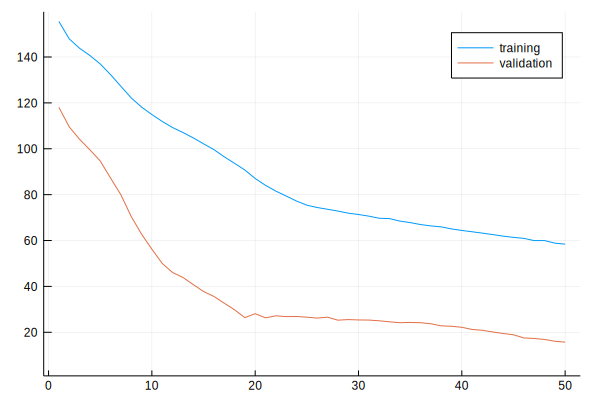

 11.312607 seconds (24.77 M allocations: 1.696 GiB, 7.07% gc time)


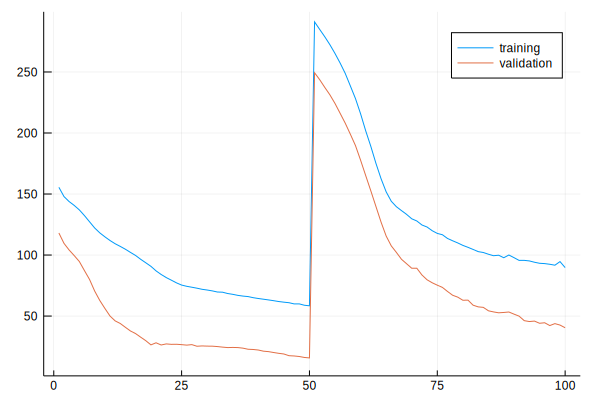

 11.565849 seconds (34.58 M allocations: 2.430 GiB, 9.57% gc time)


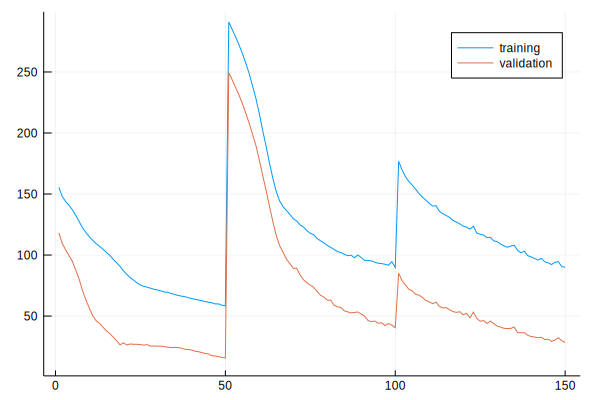

 15.458392 seconds (46.14 M allocations: 3.241 GiB, 9.51% gc time)


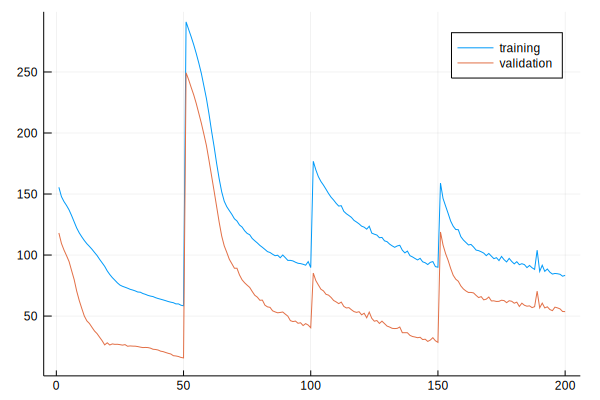

 27.130690 seconds (80.03 M allocations: 5.622 GiB, 9.82% gc time)


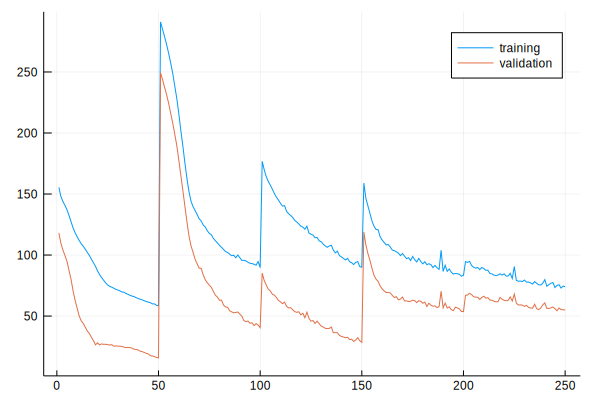

 38.455325 seconds (113.92 M allocations: 8.003 GiB, 10.43% gc time)


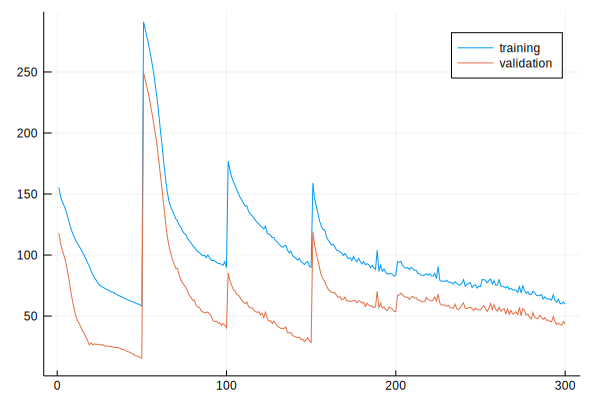

 44.575742 seconds (136.64 M allocations: 9.600 GiB, 9.82% gc time)


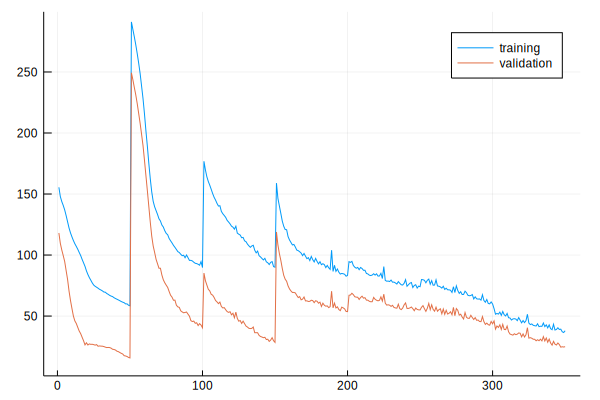

 52.581485 seconds (159.36 M allocations: 11.196 GiB, 10.13% gc time)


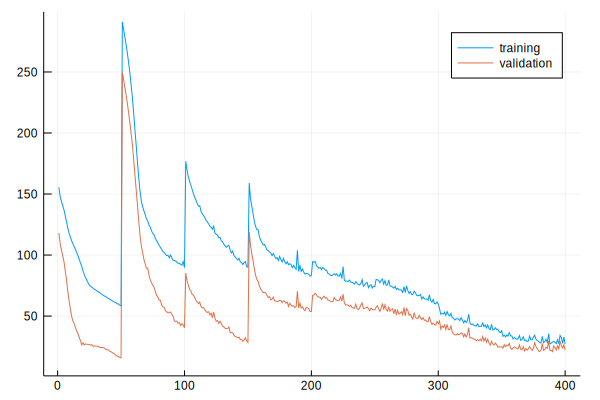

 64.360136 seconds (193.25 M allocations: 13.577 GiB, 9.57% gc time)


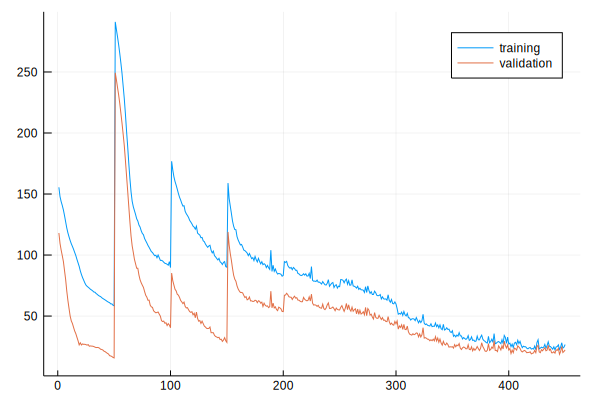

 75.210278 seconds (227.14 M allocations: 15.958 GiB, 10.07% gc time)


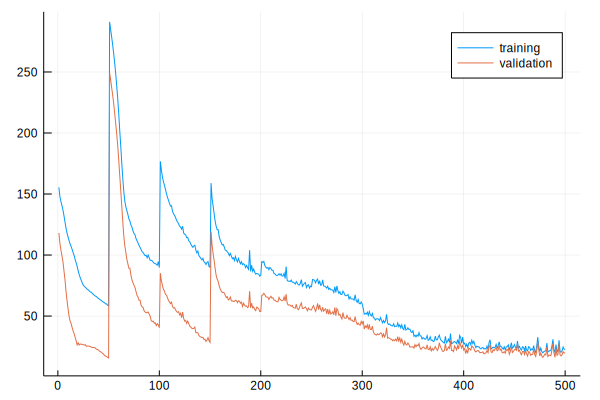

 85.891062 seconds (261.03 M allocations: 18.338 GiB, 9.60% gc time)


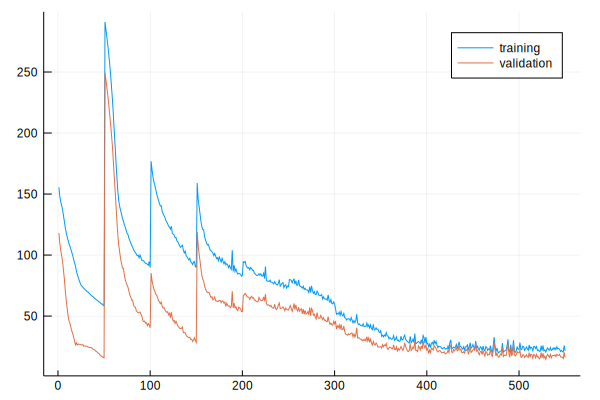

 94.573815 seconds (283.88 M allocations: 19.944 GiB, 10.24% gc time)


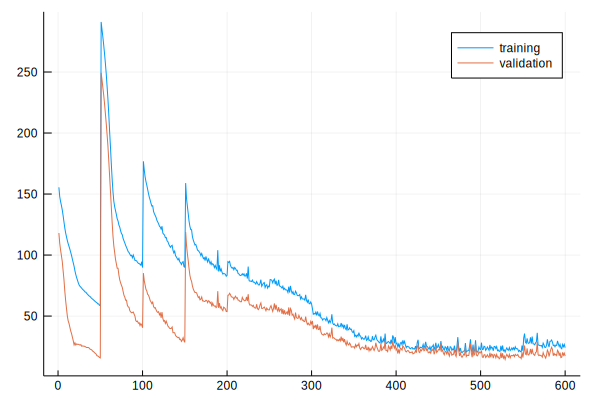

108.054533 seconds (317.77 M allocations: 22.325 GiB, 9.49% gc time)


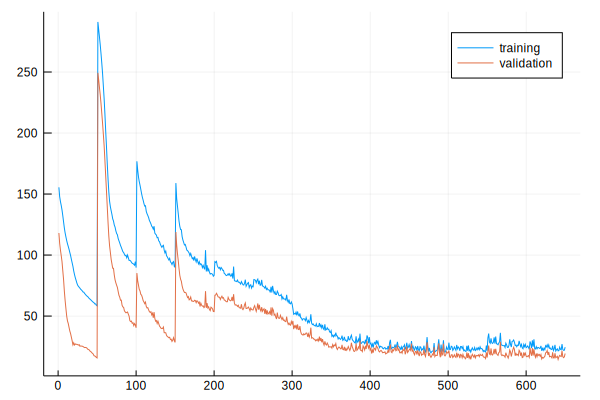

114.813633 seconds (340.49 M allocations: 23.921 GiB, 9.95% gc time)


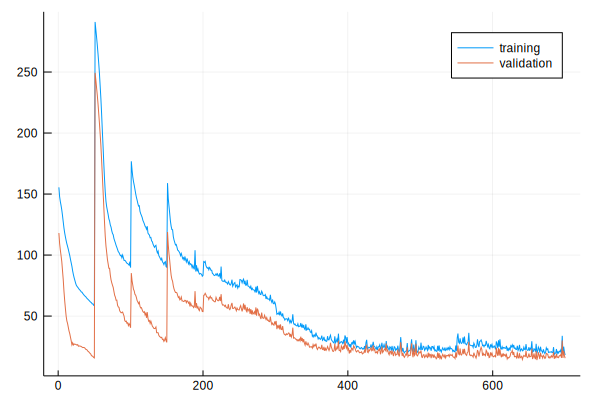

126.220675 seconds (374.38 M allocations: 26.302 GiB, 9.54% gc time)


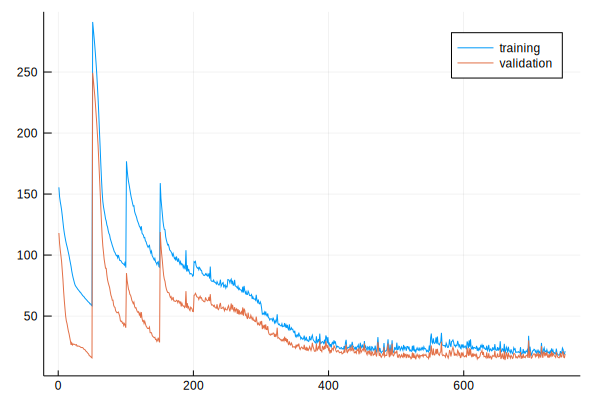

137.146519 seconds (408.27 M allocations: 28.683 GiB, 10.08% gc time)


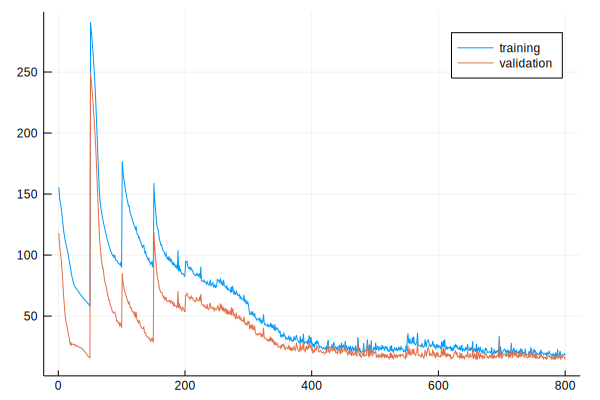

150.548501 seconds (442.16 M allocations: 31.064 GiB, 9.53% gc time)


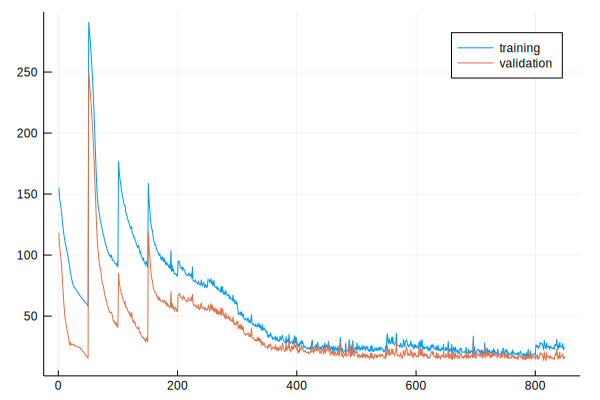

162.660966 seconds (476.04 M allocations: 33.445 GiB, 9.93% gc time)


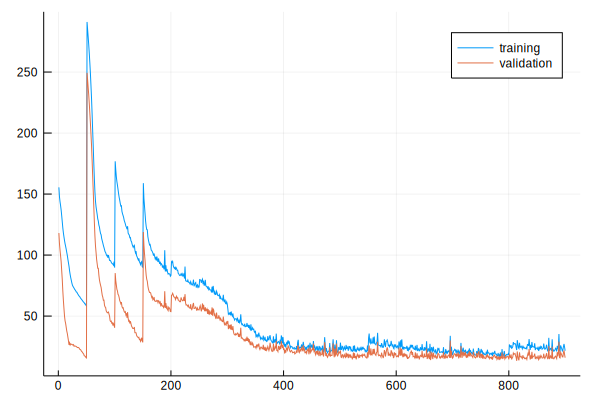

172.342026 seconds (509.93 M allocations: 35.825 GiB, 9.68% gc time)


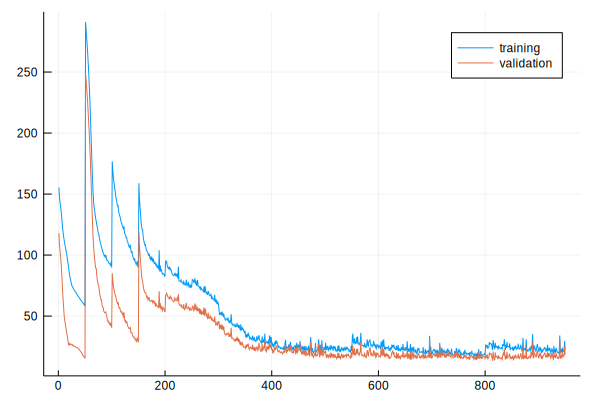

181.872380 seconds (543.82 M allocations: 38.206 GiB, 9.90% gc time)


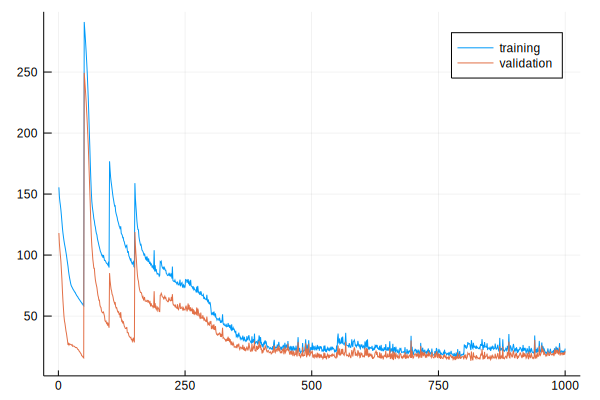

193.283327 seconds (577.71 M allocations: 40.587 GiB, 10.13% gc time)


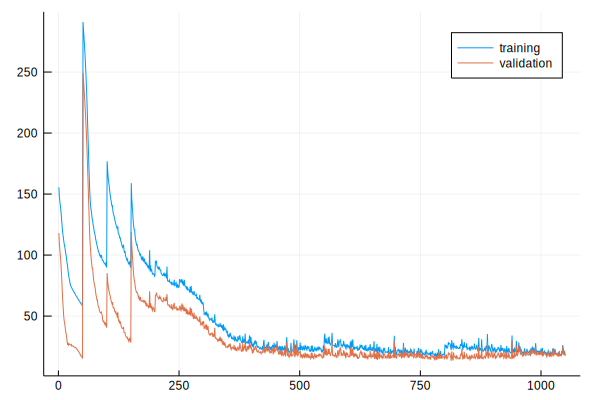

202.924077 seconds (611.60 M allocations: 42.968 GiB, 9.90% gc time)


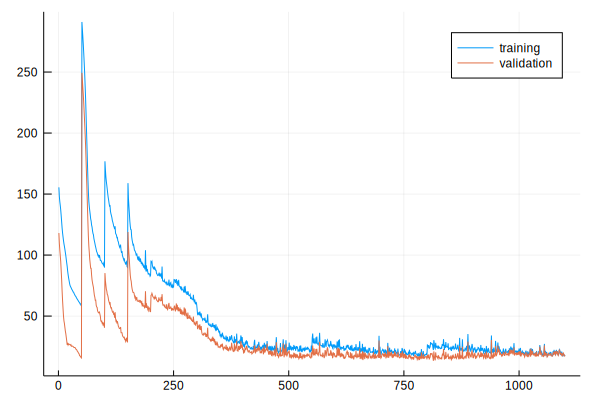

210.865135 seconds (634.32 M allocations: 44.564 GiB, 9.99% gc time)


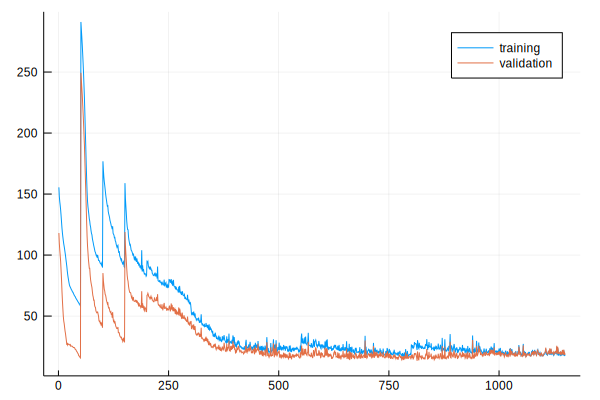

216.700248 seconds (657.74 M allocations: 46.210 GiB, 9.65% gc time)


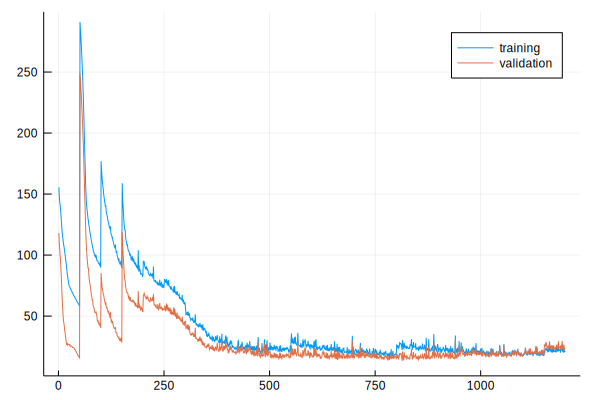

225.540407 seconds (682.85 M allocations: 47.974 GiB, 9.98% gc time)


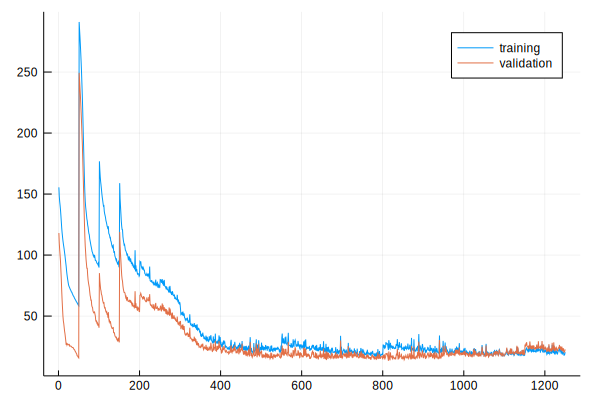

236.614451 seconds (716.74 M allocations: 50.355 GiB, 9.54% gc time)


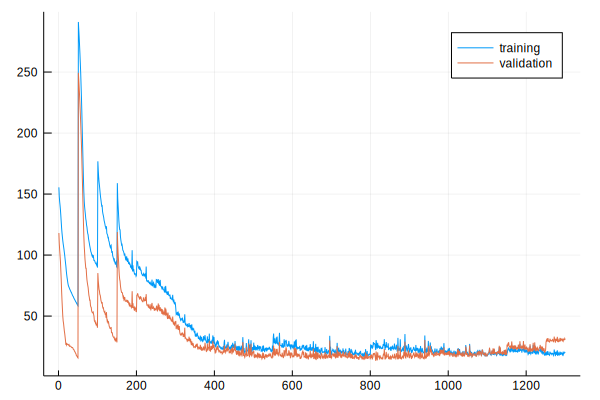

243.529356 seconds (739.46 M allocations: 51.951 GiB, 9.81% gc time)


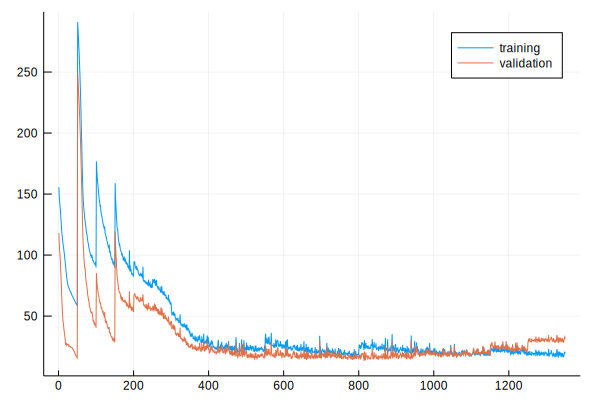

256.116541 seconds (773.35 M allocations: 54.332 GiB, 9.54% gc time)


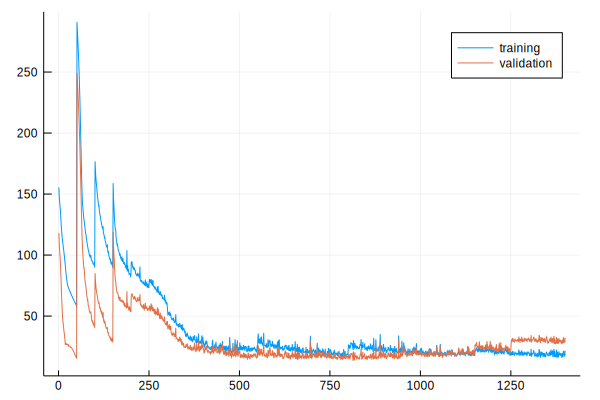

263.981054 seconds (796.07 M allocations: 55.928 GiB, 9.98% gc time)


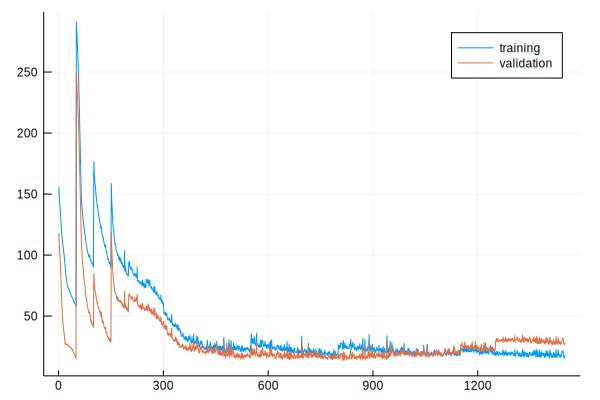

275.134604 seconds (829.96 M allocations: 58.309 GiB, 9.76% gc time)


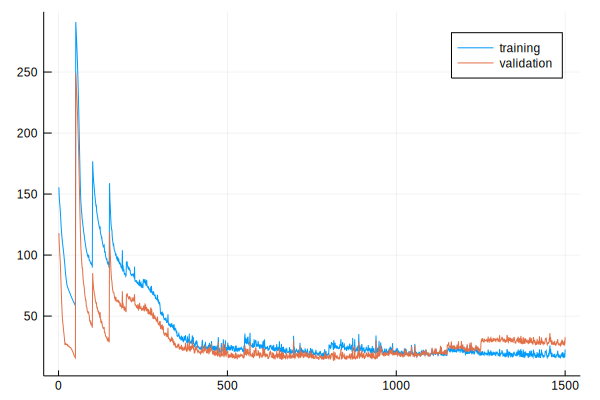

285.368354 seconds (852.68 M allocations: 59.905 GiB, 10.44% gc time)


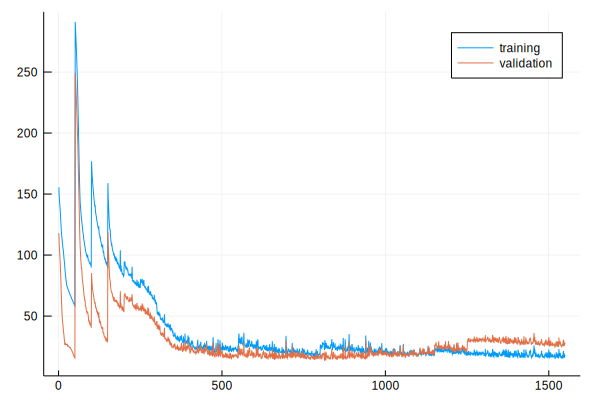

294.413937 seconds (886.57 M allocations: 62.286 GiB, 10.11% gc time)


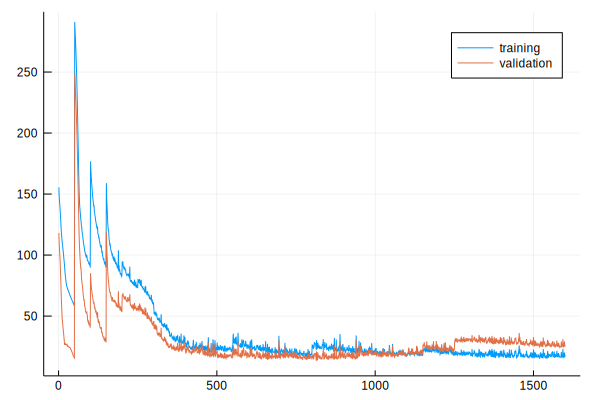

297.930061 seconds (898.70 M allocations: 63.138 GiB, 9.88% gc time)


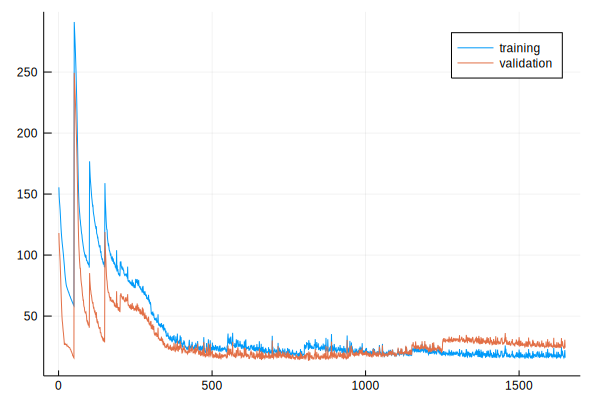

309.538380 seconds (932.58 M allocations: 65.519 GiB, 10.09% gc time)


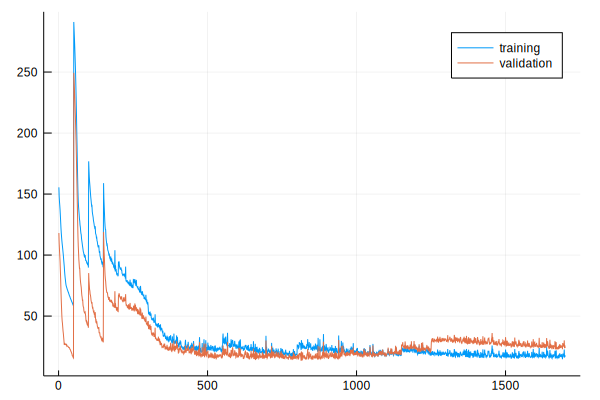

322.041085 seconds (966.47 M allocations: 67.899 GiB, 10.25% gc time)


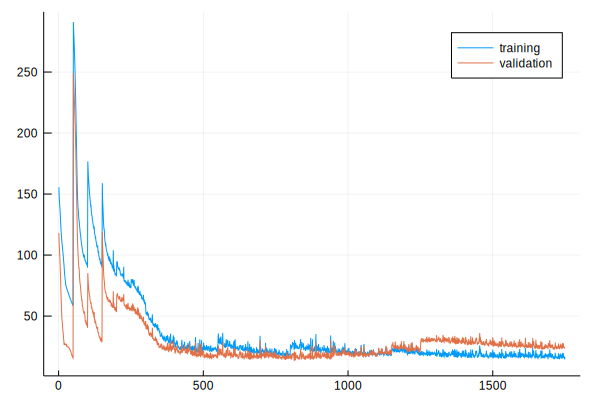

333.745750 seconds (1.00 G allocations: 70.280 GiB, 10.35% gc time)


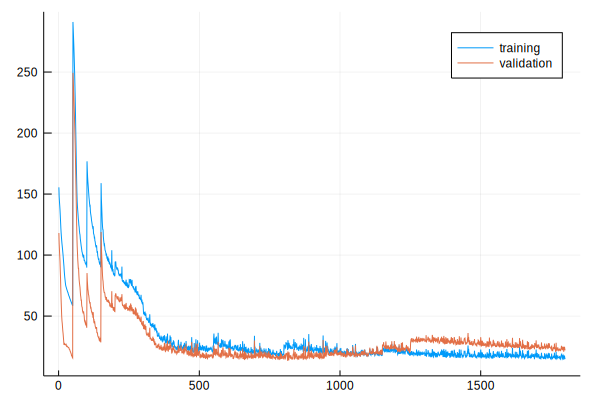

344.933264 seconds (1.03 G allocations: 72.661 GiB, 10.35% gc time)


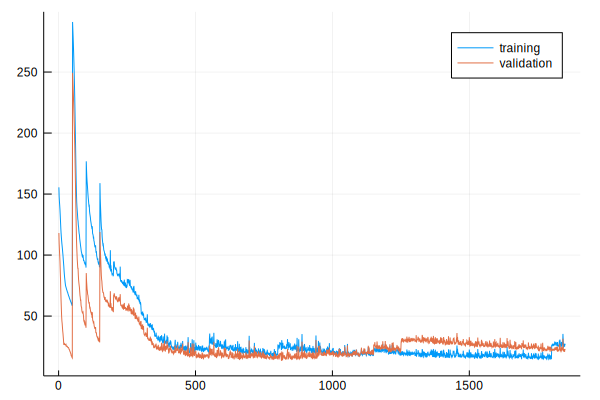

352.771825 seconds (1.06 G allocations: 74.337 GiB, 10.35% gc time)


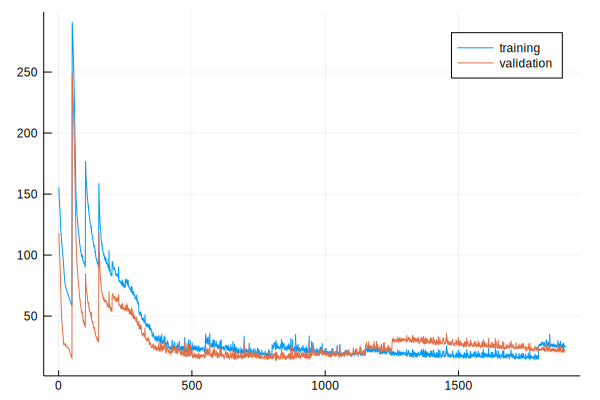

365.055003 seconds (1.09 G allocations: 76.718 GiB, 10.25% gc time)


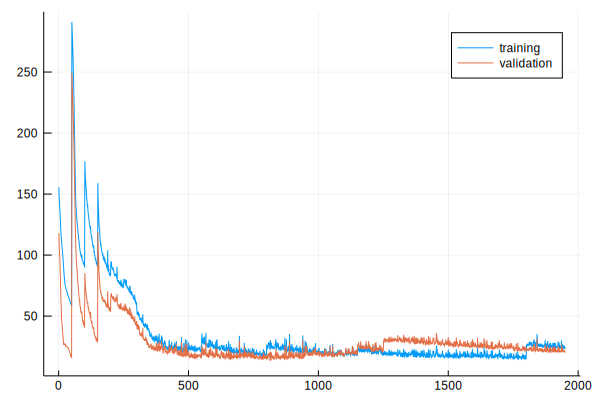

372.239370 seconds (1.11 G allocations: 78.314 GiB, 10.28% gc time)


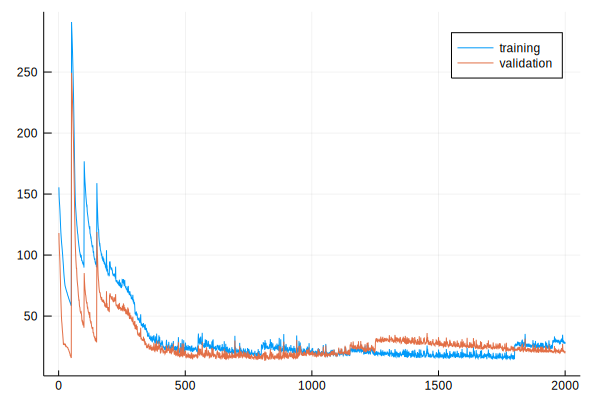

384.289464 seconds (1.15 G allocations: 80.695 GiB, 10.08% gc time)


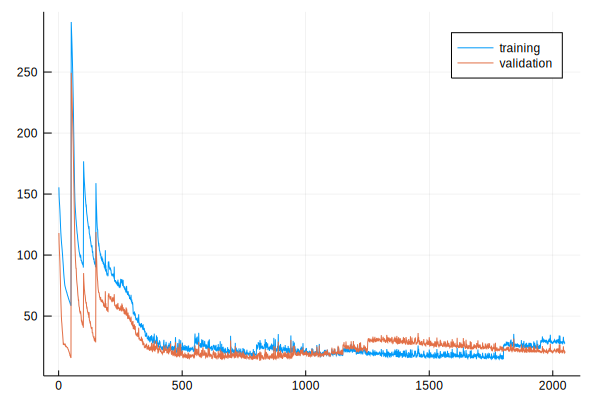

392.335851 seconds (1.18 G allocations: 83.076 GiB, 10.05% gc time)


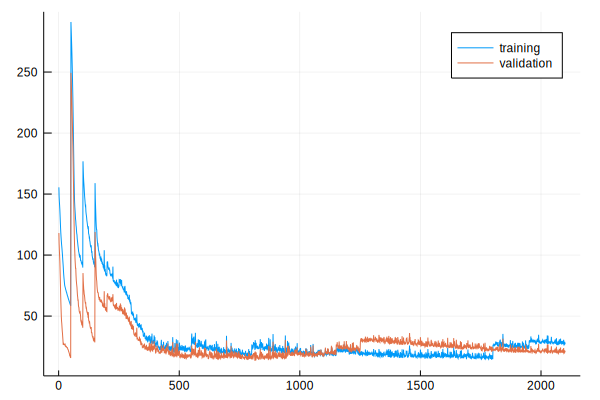

400.311344 seconds (1.22 G allocations: 85.457 GiB, 9.49% gc time)


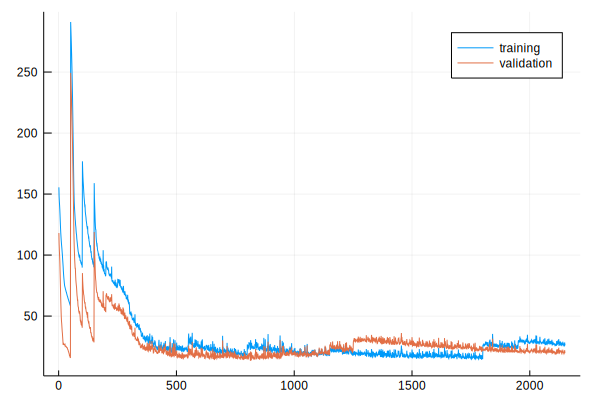

416.443131 seconds (1.25 G allocations: 87.838 GiB, 10.24% gc time)


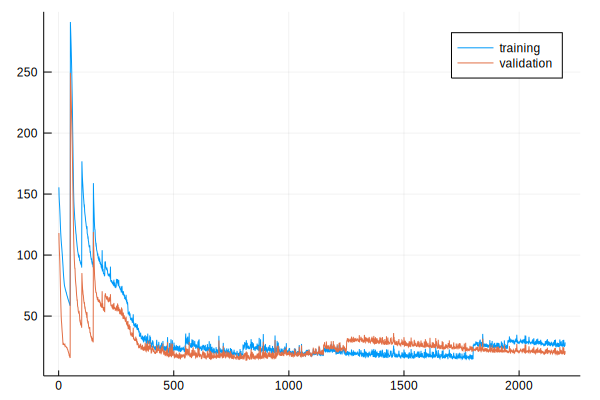

423.952112 seconds (1.28 G allocations: 90.218 GiB, 9.75% gc time)


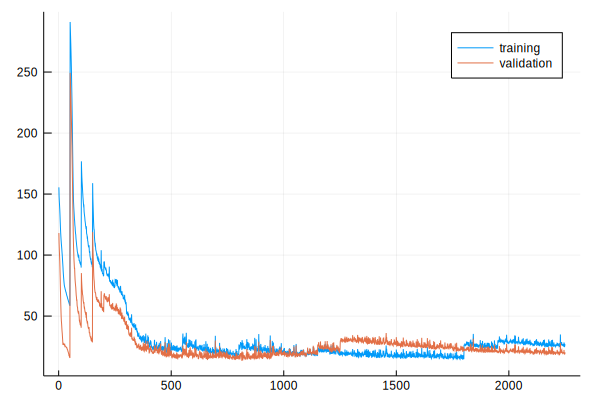

433.884110 seconds (1.32 G allocations: 92.599 GiB, 9.41% gc time)


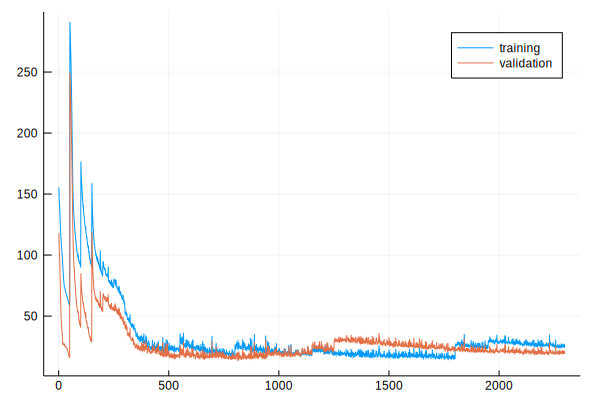

446.605337 seconds (1.35 G allocations: 94.980 GiB, 9.80% gc time)


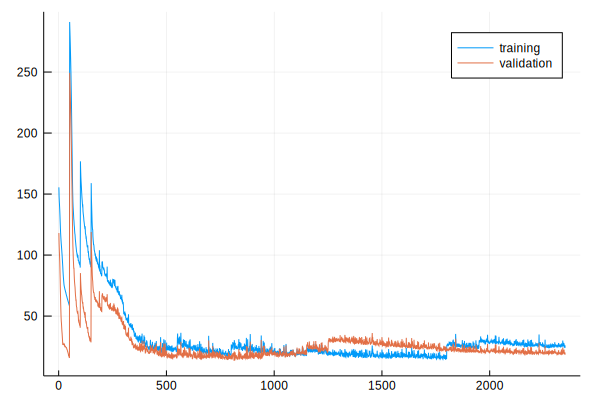

452.484145 seconds (1.37 G allocations: 96.576 GiB, 9.64% gc time)


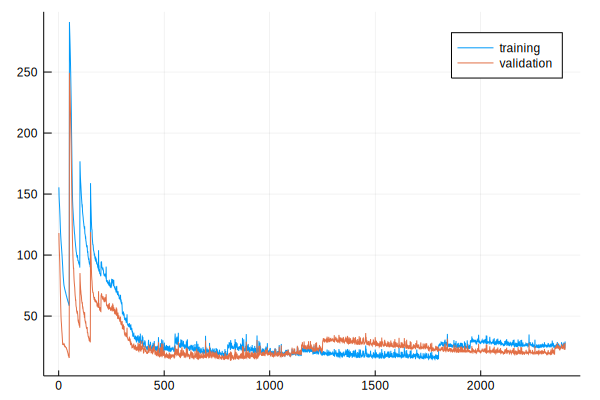

458.419126 seconds (1.40 G allocations: 98.173 GiB, 9.46% gc time)


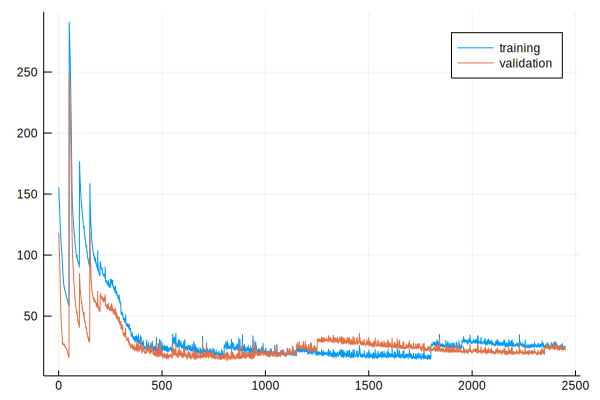

473.293423 seconds (1.43 G allocations: 100.554 GiB, 9.77% gc time)


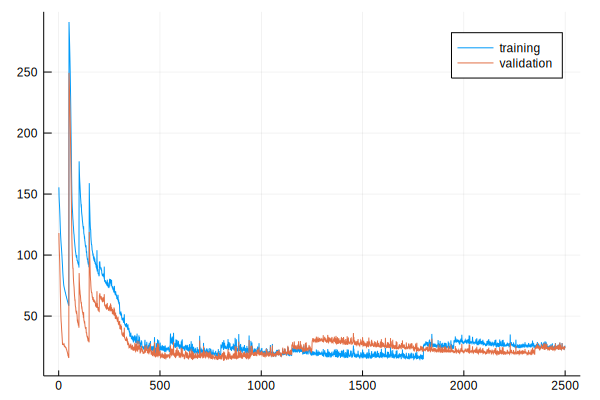

481.982933 seconds (1.47 G allocations: 102.935 GiB, 9.75% gc time)


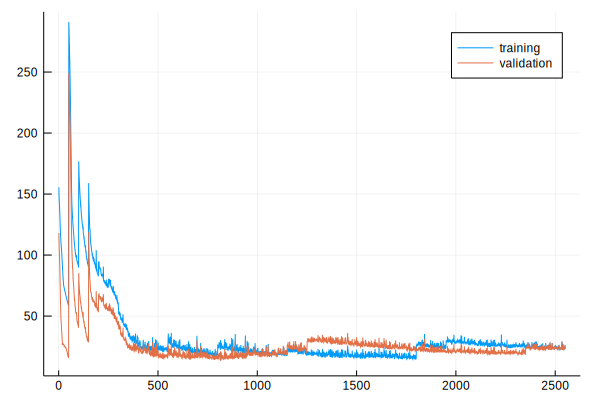

491.747864 seconds (1.50 G allocations: 105.315 GiB, 9.57% gc time)


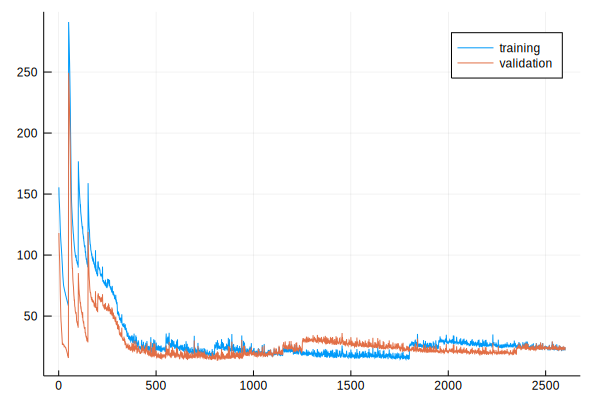

502.645300 seconds (1.52 G allocations: 106.912 GiB, 9.94% gc time)


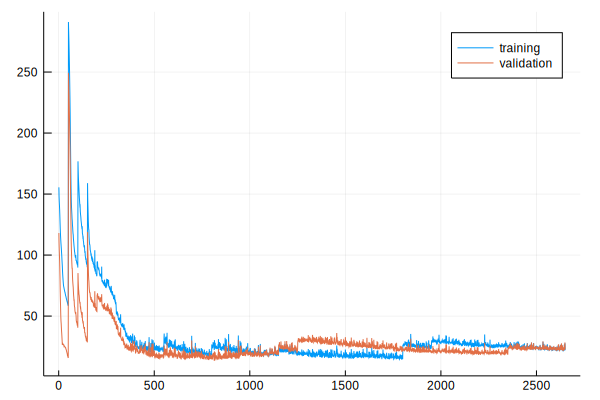

510.973734 seconds (1.54 G allocations: 108.508 GiB, 9.54% gc time)


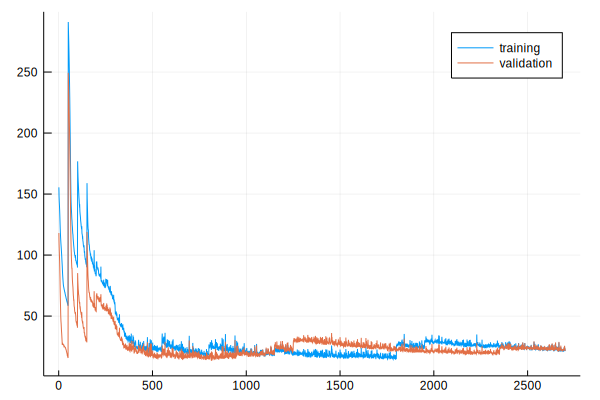

524.383309 seconds (1.58 G allocations: 110.889 GiB, 10.00% gc time)


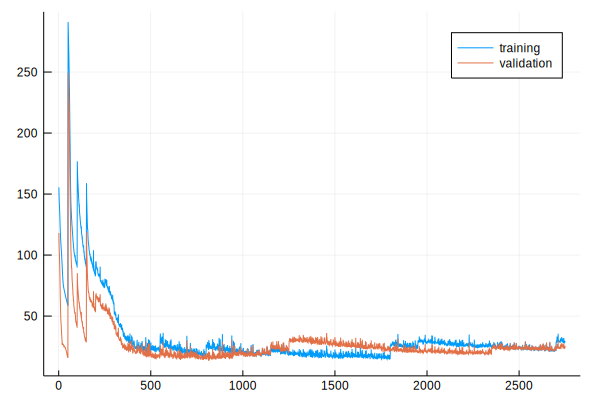

527.503925 seconds (1.59 G allocations: 111.713 GiB, 9.77% gc time)


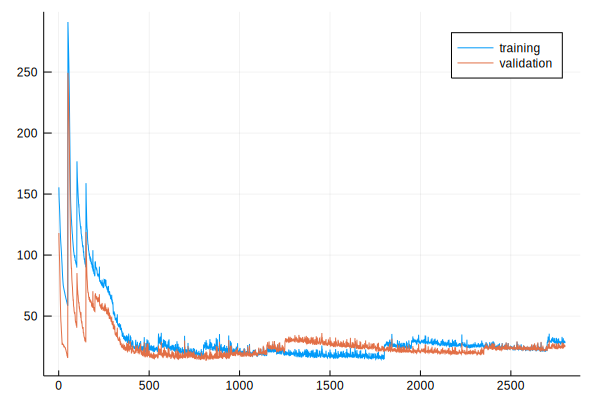

538.567198 seconds (1.62 G allocations: 114.094 GiB, 9.70% gc time)


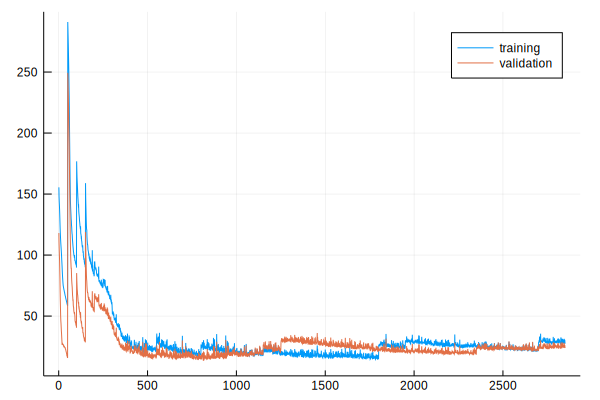

548.722281 seconds (1.65 G allocations: 115.690 GiB, 10.17% gc time)


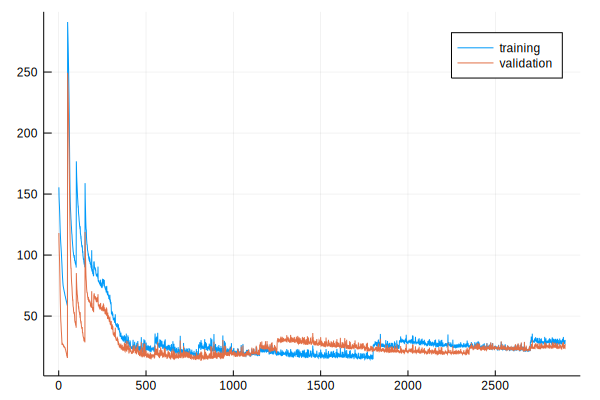

558.256318 seconds (1.68 G allocations: 118.071 GiB, 10.16% gc time)


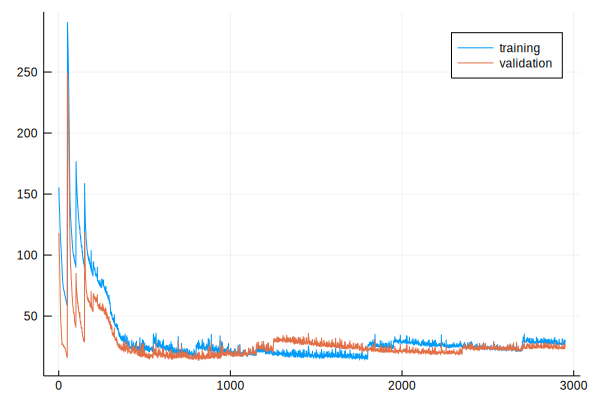

570.061626 seconds (1.71 G allocations: 120.452 GiB, 10.18% gc time)


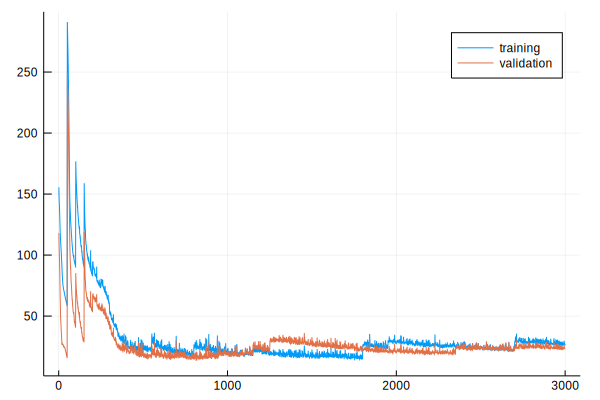

578.023811 seconds (1.75 G allocations: 122.833 GiB, 10.04% gc time)


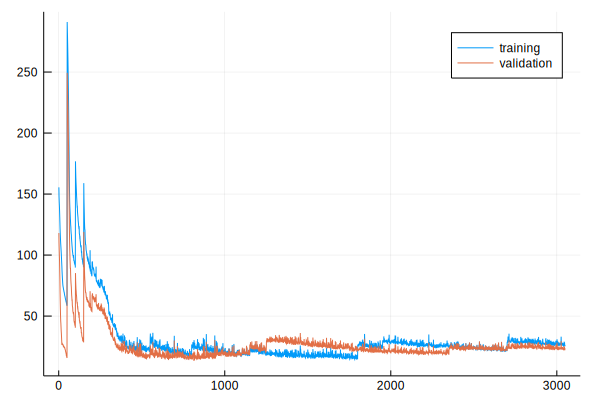

592.712775 seconds (1.78 G allocations: 125.214 GiB, 10.18% gc time)


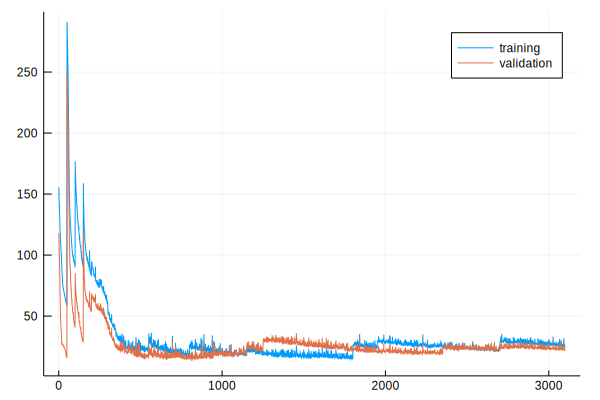

603.949909 seconds (1.82 G allocations: 127.595 GiB, 10.06% gc time)


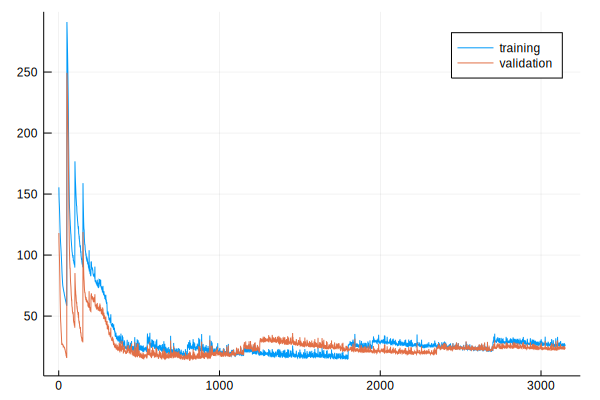

613.449742 seconds (1.84 G allocations: 129.222 GiB, 9.99% gc time)


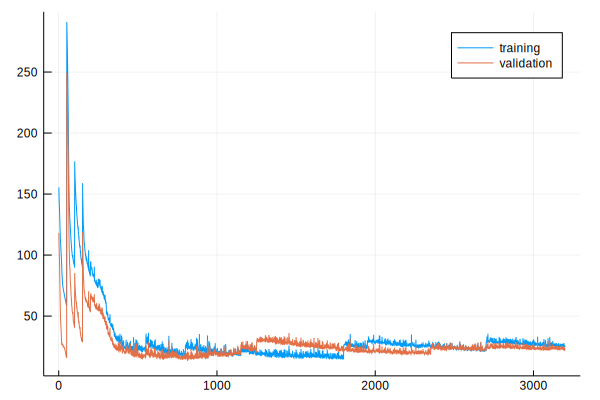

625.197598 seconds (1.87 G allocations: 131.602 GiB, 10.03% gc time)


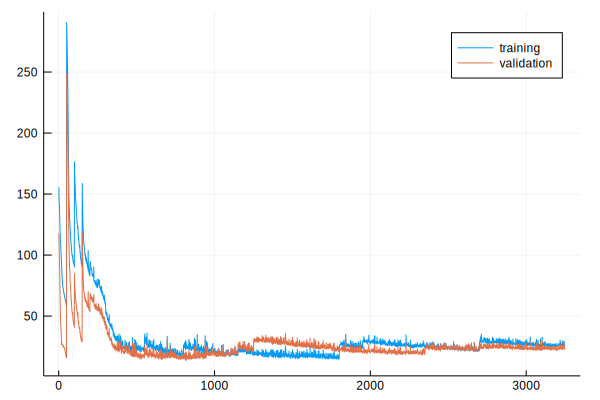

631.076191 seconds (1.89 G allocations: 132.573 GiB, 10.05% gc time)


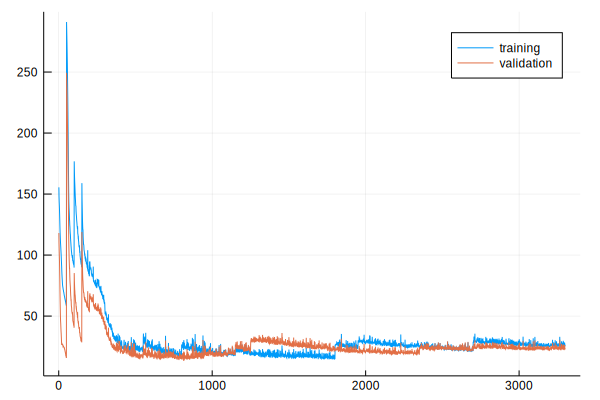

639.305515 seconds (1.92 G allocations: 134.954 GiB, 10.19% gc time)


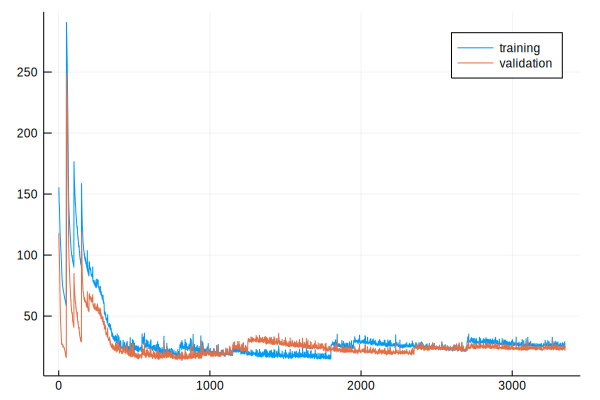

648.134818 seconds (1.95 G allocations: 137.335 GiB, 10.10% gc time)


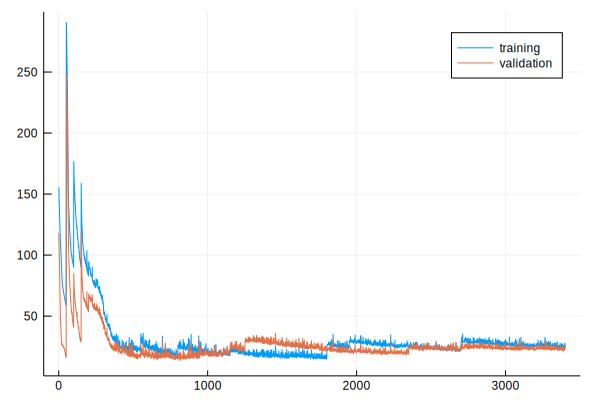

660.472457 seconds (1.99 G allocations: 139.716 GiB, 10.21% gc time)


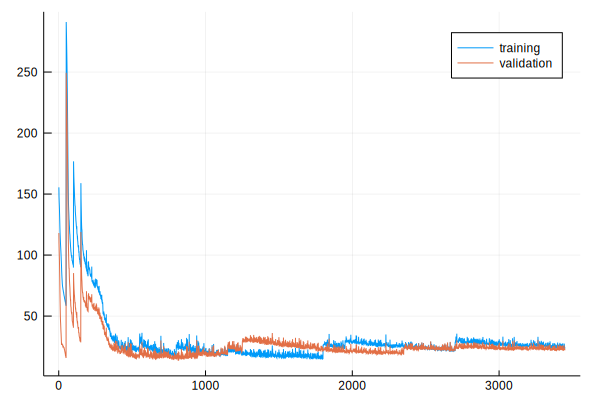

672.064684 seconds (2.02 G allocations: 142.096 GiB, 10.20% gc time)


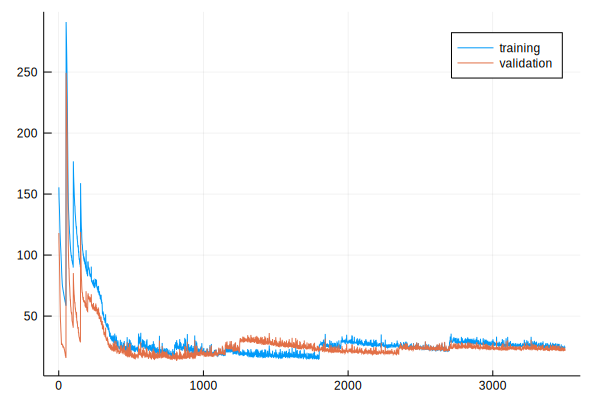

683.754569 seconds (2.06 G allocations: 144.477 GiB, 10.26% gc time)


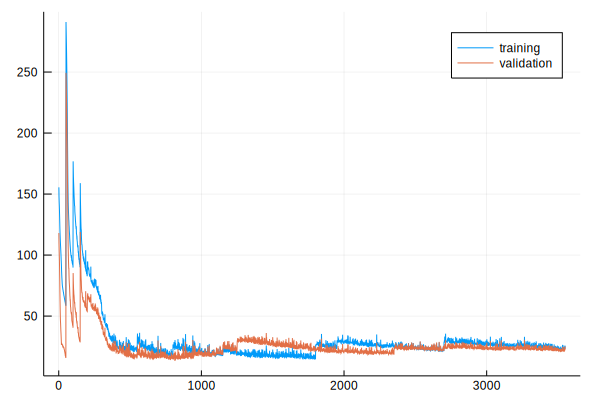

693.502505 seconds (2.09 G allocations: 146.858 GiB, 10.08% gc time)


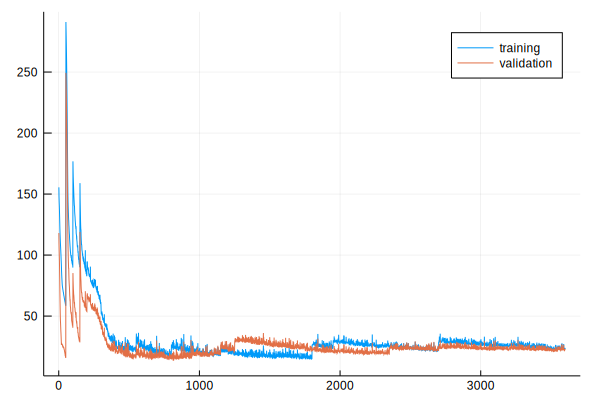

707.948813 seconds (2.12 G allocations: 149.239 GiB, 10.34% gc time)


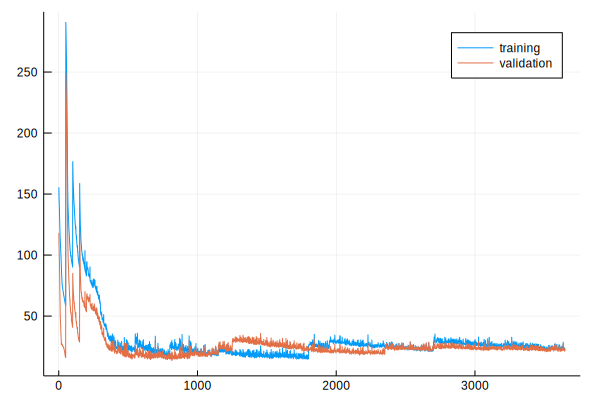

717.357080 seconds (2.16 G allocations: 151.620 GiB, 10.30% gc time)


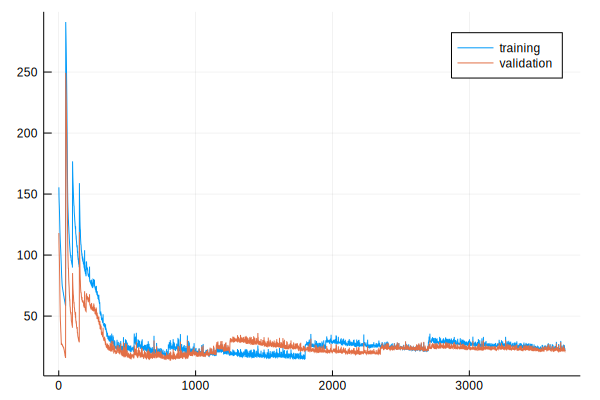

729.650544 seconds (2.19 G allocations: 154.001 GiB, 10.15% gc time)


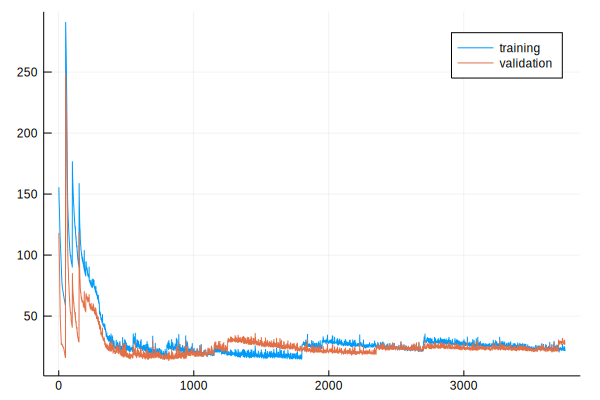

736.923355 seconds (2.21 G allocations: 155.597 GiB, 10.08% gc time)


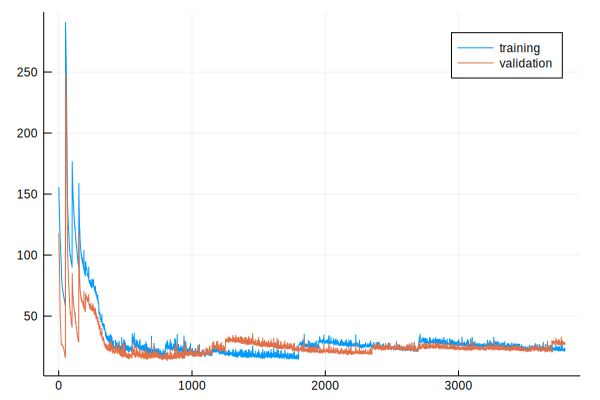

749.581405 seconds (2.25 G allocations: 157.978 GiB, 10.27% gc time)


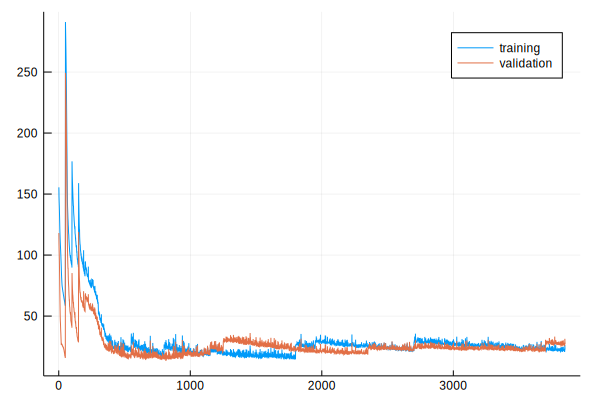

762.178583 seconds (2.28 G allocations: 160.359 GiB, 10.32% gc time)


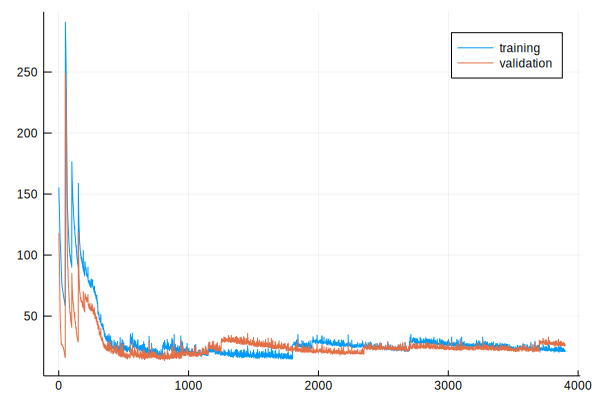

767.863188 seconds (2.32 G allocations: 162.740 GiB, 9.62% gc time)


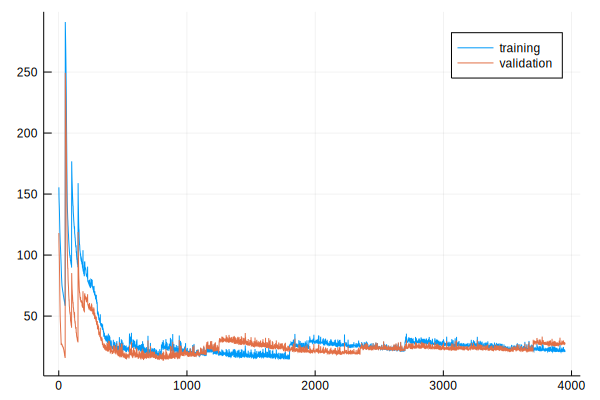

776.248990 seconds (2.34 G allocations: 164.348 GiB, 9.48% gc time)


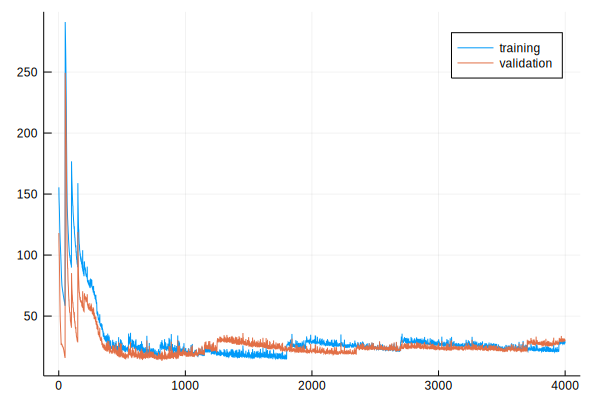

772.705036 seconds (2.35 G allocations: 165.203 GiB, 9.46% gc time)


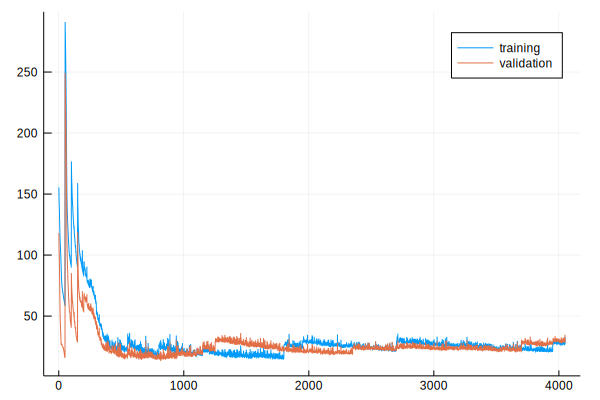

787.211363 seconds (2.39 G allocations: 167.584 GiB, 9.07% gc time)


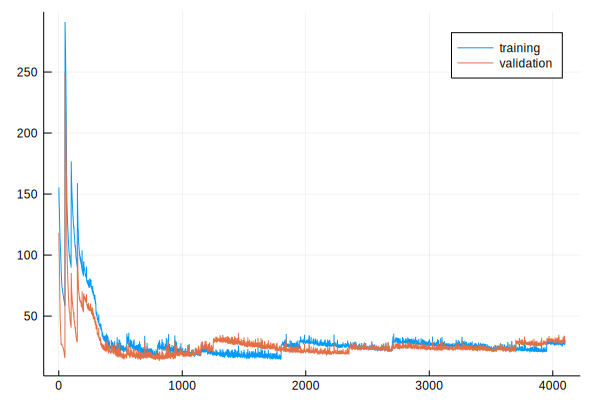

800.079271 seconds (2.42 G allocations: 169.965 GiB, 9.50% gc time)


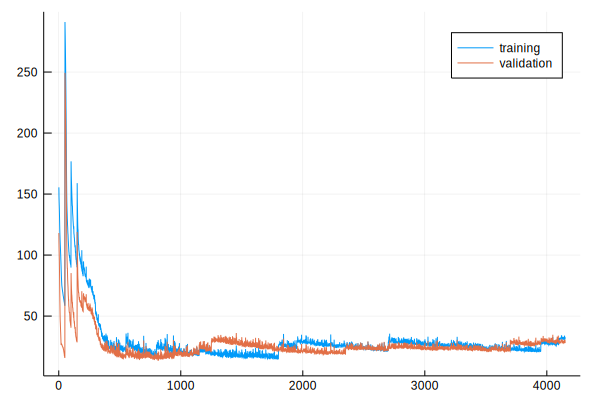

807.258596 seconds (2.45 G allocations: 172.337 GiB, 9.44% gc time)


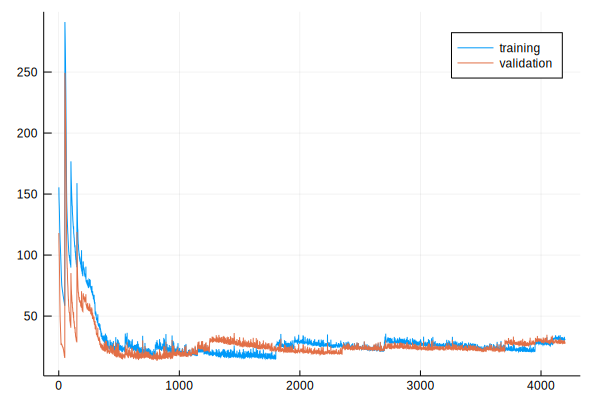

815.310052 seconds (2.49 G allocations: 174.718 GiB, 8.92% gc time)


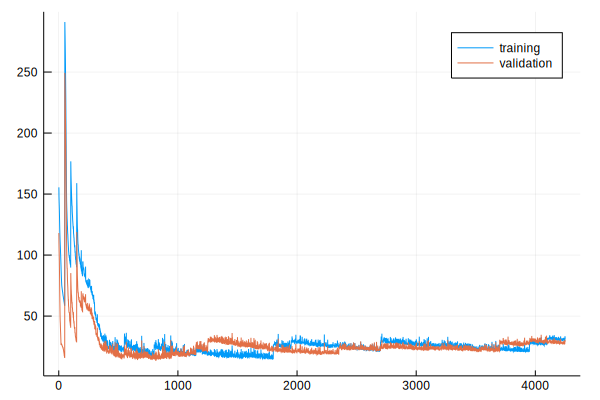

837.392243 seconds (2.52 G allocations: 177.098 GiB, 9.45% gc time)


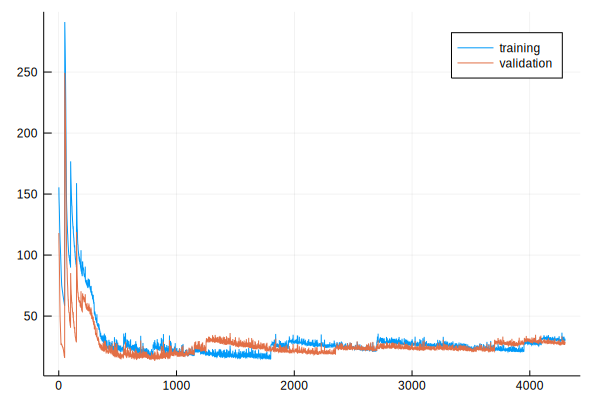

837.190491 seconds (2.54 G allocations: 178.695 GiB, 9.43% gc time)


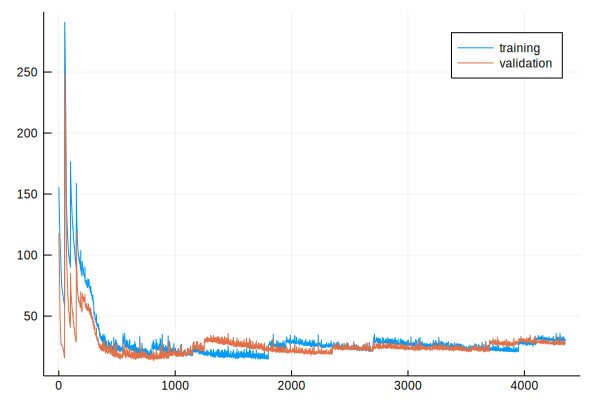

Progress:  87%|████████████████████████████████████     |  ETA: 2:10:27

843.771476 seconds (2.57 G allocations: 180.303 GiB, 9.03% gc time)


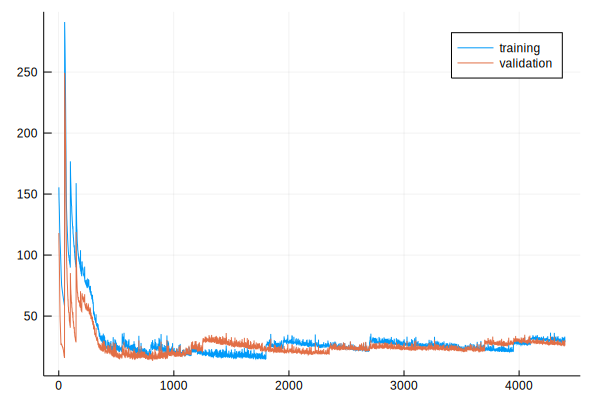

855.742320 seconds (2.60 G allocations: 182.684 GiB, 9.07% gc time)


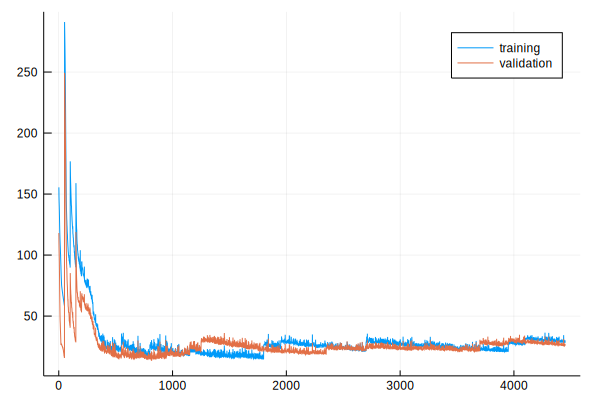

866.826852 seconds (2.63 G allocations: 185.065 GiB, 9.06% gc time)


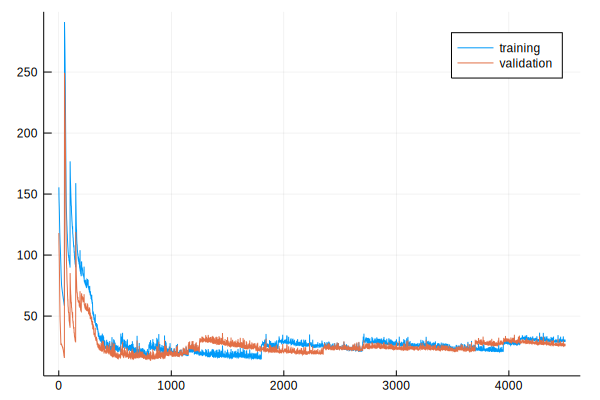

871.499276 seconds (2.65 G allocations: 185.889 GiB, 9.12% gc time)


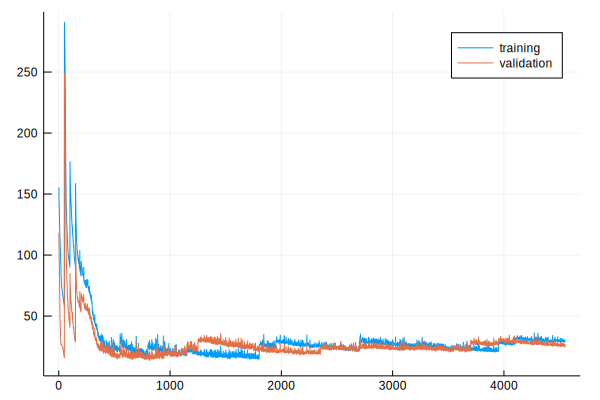

880.504238 seconds (2.68 G allocations: 188.270 GiB, 9.39% gc time)


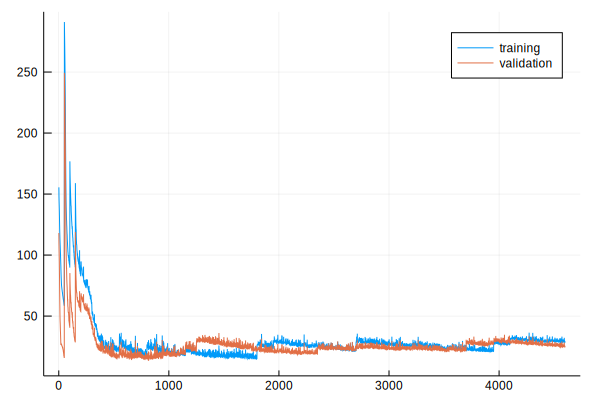

886.861579 seconds (2.70 G allocations: 189.867 GiB, 9.40% gc time)


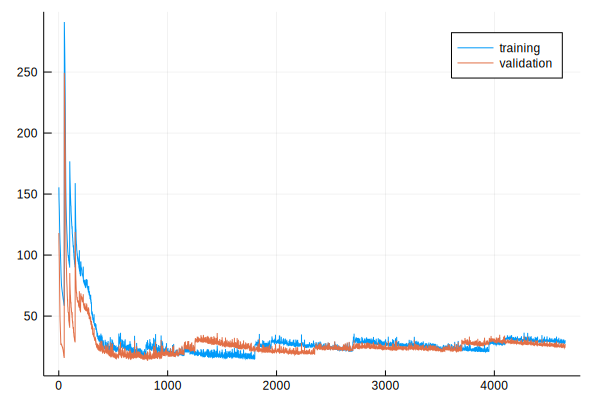

903.411794 seconds (2.74 G allocations: 192.247 GiB, 9.37% gc time)


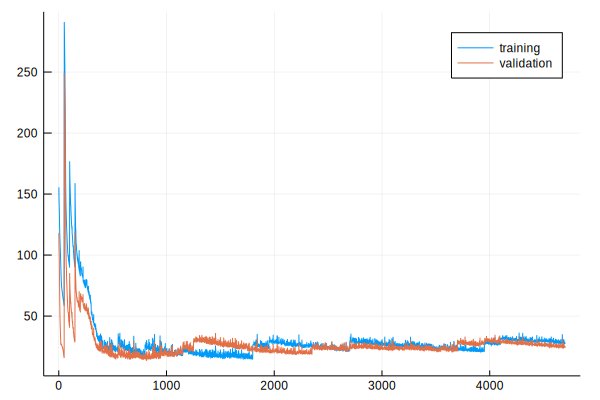

914.162955 seconds (2.77 G allocations: 194.628 GiB, 9.38% gc time)


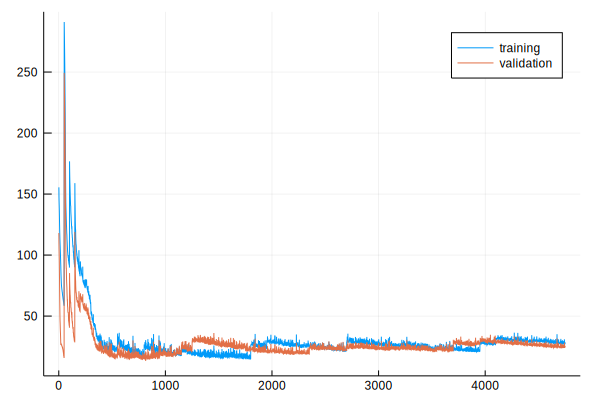

922.963997 seconds (2.79 G allocations: 196.225 GiB, 9.36% gc time)


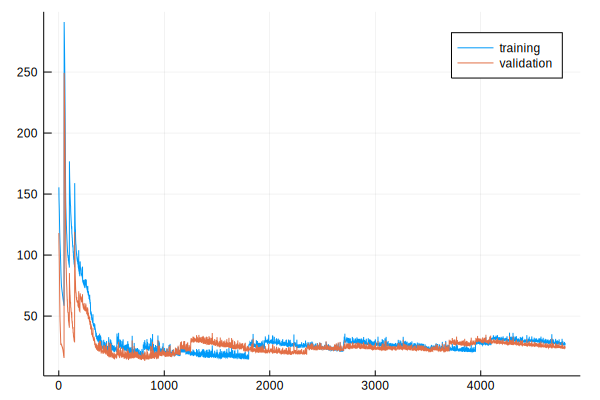

936.627965 seconds (2.83 G allocations: 198.606 GiB, 9.18% gc time)


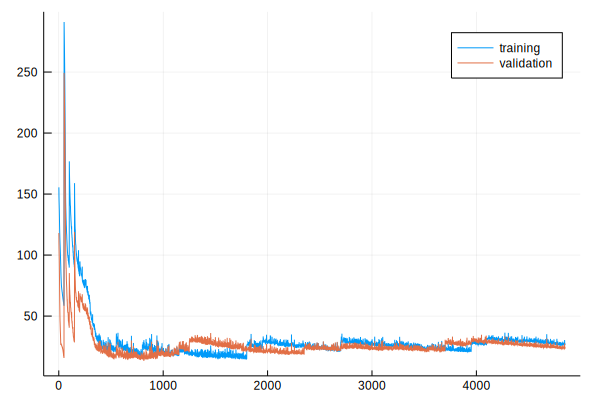

952.088712 seconds (2.86 G allocations: 200.986 GiB, 9.43% gc time)


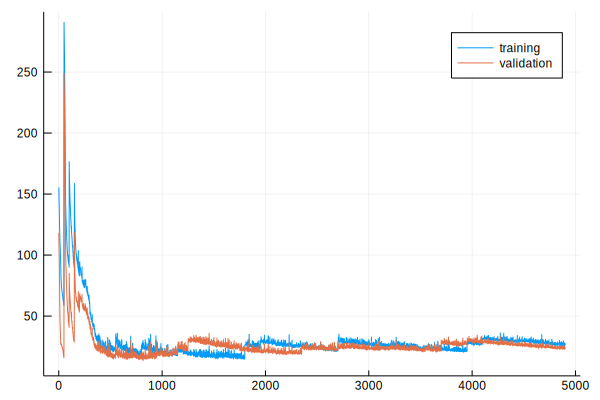

957.439403 seconds (2.89 G allocations: 203.367 GiB, 9.05% gc time)


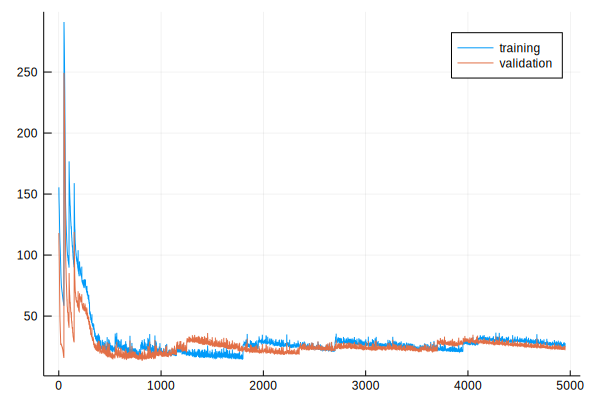

965.267039 seconds (2.93 G allocations: 205.748 GiB, 9.34% gc time)


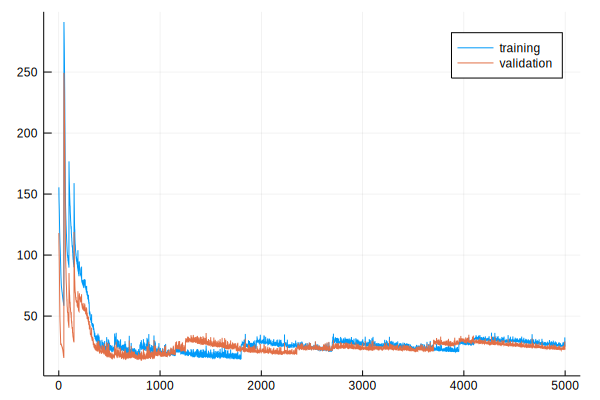

983.683100 seconds (2.96 G allocations: 208.129 GiB, 9.38% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 18:28:37


In [130]:
datasets = Vector{LearningMPC.Dataset{Float64}}()
losses = Vector{Tuple{Float64, Float64}}()

N_iter = 100
σv = 5.0

@showprogress for i in 1:N_iter
    dataset = LearningMPC.Dataset(lqrsol)
    wall_distance = rand(linspace(0.5, 2.0, 100))
    collect_into!(dataset.training_data, σv, wall_distance)
    wall_distance = rand(linspace(0.5, 2.0, 100))
    collect_into!(dataset.training_data, 0.1 * σv, wall_distance)
    wall_distance = rand(linspace(0.5, 2.0, 100))
    collect_into!(dataset.training_data, 0.01 * σv, wall_distance)
    
    filter!(dataset.training_data) do sample
        all(isfinite, sample.input)
    end

    
    new_samples = tuple.(dataset.training_data)
    if !isempty(new_samples)
        new_training, new_validation = splitobs(shuffleobs(new_samples); at=0.8)
        append!(all_training_data, new_training)
        append!(all_validation_data, new_validation)
    end

    @time for i in 1:50
        Flux.train!(loss, shuffleobs(all_training_data), optimizer)
        push!(losses, 
            (mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_training_data),
             mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_validation_data)))
    end
    push!(datasets, dataset)
    
    jldopen(dataset_file, "w") do file
        file["datasets"] = datasets
        file["net"] = net
        file["lqrsol"] = lqrsol
        file["mpc_params"] = Dict(
            "Δt" => params.Δt, 
            "horizon" => params.horizon,
        )
        file["losses"] = losses
    end
    
    jldopen(library_file, "w") do file
        file["training"] = all_training_data
        file["testing"] = all_validation_data
    end
    
    plt = plot(first.(losses), label="training")
    plot!(plt, last.(losses), label="validation")
    ylims!(plt, (1, ylims(plt)[2]))
    display(plt)

end